In [4]:
pip install statsmodels

     |████████████████████████████████| 9.9 MB 3.4 MB/s eta 0:00:01
  Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
You should consider upgrading via the '/Users/sushantkotwal96/tensorflow_vs_code/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sms
import matplotlib.pyplot as plt

In [6]:
df_airline = pd.read_csv('airline_passengers.csv')

In [7]:
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [9]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    145 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [10]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [11]:
df_airline.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [12]:
df_airline.dropna(inplace=True,axis=0)

In [14]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [15]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


### Here the month is an object type, so we will convert it to a datetime type

In [17]:
df_airline['Month'] = pd.to_datetime(df_airline['Month'])

In [18]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [19]:
df_airline.set_index('Month',inplace=True)

In [20]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

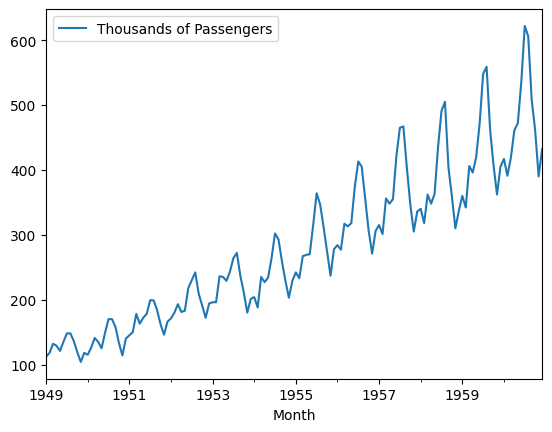

In [21]:
df_airline.plot()

### The above plot shows seasonality and trend. So, since this is a seasonal data, it cannot be a stationary data

### We will now use Dickey-Fuller test to check stationarity of the data

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
result = adfuller(df_airline['Thousands of Passengers'])

In [40]:
def adf(series):
    result = adfuller(series)
    
## The null hypothesis here was that the data is non-stationary
    print('ADF Statistics: {}'.format(result[0]))
    print('p-Value: {}'.format(result[1]))
    if result[1]<=0.05:
        print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is Stationary")
    else:
        print("Accept the null hypothesis. Time series has a unit root, indicating this data is non-stationary")

### To make the data stationary, we will do differencing

In [33]:
df_airline['Passengers_first_difference'] = df_airline['Thousands of Passengers']-df_airline['Thousands of Passengers'].shift(1)

In [34]:
df_airline

,Thousands of Passengers,Passengers_first_difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0
...,...,...
1960-08-01,606.0,-16.0
1960-09-01,508.0,-98.0
1960-10-01,461.0,-47.0


### Again check if the differenced data is stationary with the Dickey-Fuller test

In [37]:
result = adfuller(df_airline['Passengers_first_difference'].dropna())

In [38]:
print('ADF Statistics: {}'.format(result[0]))
print('p-Value: {}'.format(result[1]))
if result[1]<=0.05:
    print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is Stationary")
else:
    print("Accept the null hypothesis. Time series has a unit root, indicating this data is non-stationary")

ADF Statistics: -2.829266824169981
p-Value: 0.05421329028382792
Accept the null hypothesis. Time series has a unit root, indicating this data is non-stationary


### We see that first differencing did not make it stationary. So we can try again with second differencing. This time we calculate difference with respect to the 'Passengers_first_difference' column

In [39]:
df_airline['Passengers_second_difference'] = df_airline['Passengers_first_difference'] - df_airline['Passengers_first_difference'].shift(1)

In [42]:
adf(df_airline['Passengers_second_difference'].dropna())

ADF Statistics: -16.384231542468513
p-Value: 2.7328918500142026e-29
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is Stationary


### So second differencing made the data stationary. But we know that this is a seasonal data. So in seasonal data we should also make sure that we do 12 months differencing. So now we do 12 differencing but with respect to the original column i.e 'Thousands of Passengers'

In [43]:
df_airline['Passengers_12month_difference'] = df_airline['Thousands of Passengers']-df_airline['Thousands of Passengers'].shift(12)

In [44]:
adf(df_airline['Passengers_12month_difference'].dropna())

ADF Statistics: -3.383020726492481
p-Value: 0.011551493085514952
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is Stationary


### Note that: For Seasonal, sometimes ARIMA will not work well but SARIMAX will work well

### Now plotting the ACF and PACF plots

In [45]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### ACF and PACF plots for 2nd differencing

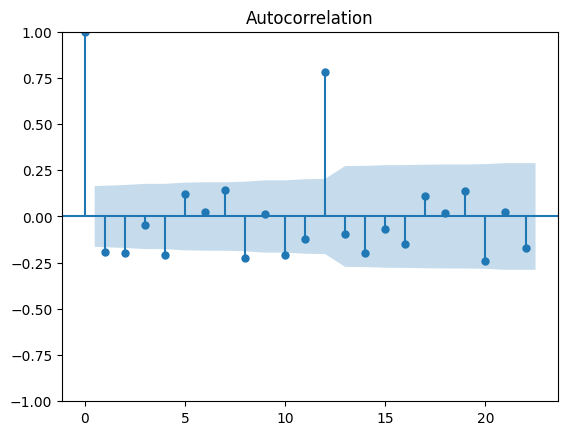

In [46]:
acf = plot_acf(df_airline['Passengers_second_difference'].dropna())

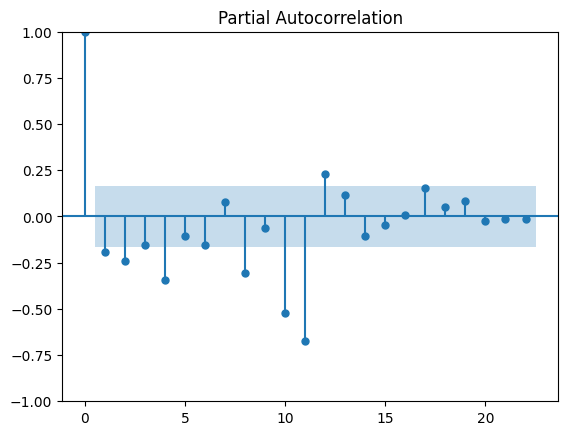

In [47]:
pacf = plot_pacf(df_airline['Passengers_second_difference'].dropna())

### ACF and PACF plots for 12month differencing

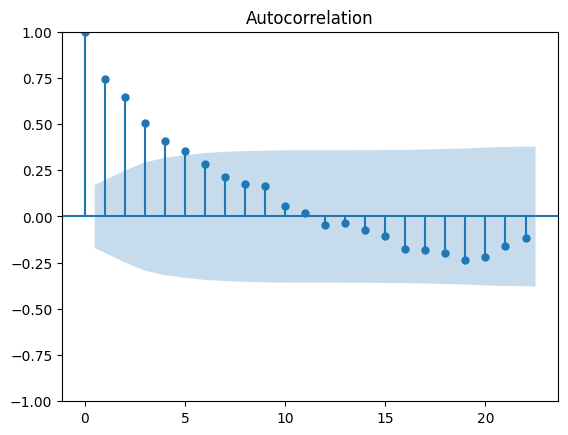

In [48]:
acf = plot_acf(df_airline['Passengers_12month_difference'].dropna())

#### From the above plot, we select q=5

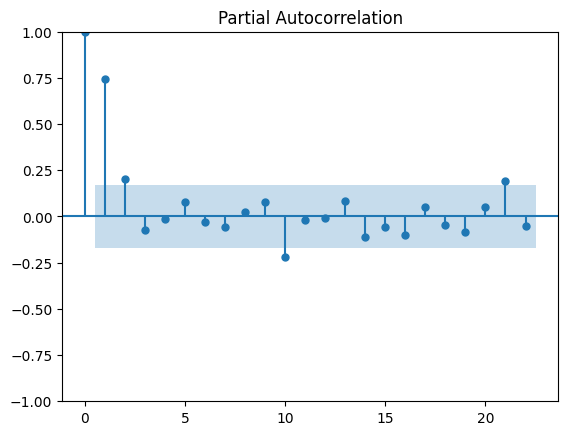

In [49]:
pacf = plot_pacf(df_airline['Passengers_12month_difference'].dropna())

In [50]:
df_airline

,Thousands of Passengers,Passengers_first_difference,Passengers_second_difference,Passengers_12month_difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1960-08-01,606.0,-16.0,-103.0,47.0
1960-09-01,508.0,-98.0,-82.0,45.0
1960-10-01,461.0,-47.0,51.0,54.0


In [51]:
from datetime import datetime,timedelta

In [52]:
train_dataset_end = datetime(1955,12,1)
test_dataset_end = datetime(1960,12,1)

In [53]:
train_data = df_airline[:train_dataset_end]
test_data = df_airline[train_dataset_end+timedelta(days=1):test_dataset_end]

In [58]:
train_data.index[83]

Timestamp('1955-12-01 00:00:00')

In [55]:
test_data.index[0]

Timestamp('1956-01-01 00:00:00')

In [59]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [61]:
test_data

,Thousands of Passengers,Passengers_first_difference,Passengers_second_difference,Passengers_12month_difference
Month,,,,
1956-01-01,284.0,6.0,-35.0,42.0
1956-02-01,277.0,-7.0,-13.0,44.0
1956-03-01,317.0,40.0,47.0,50.0
1956-04-01,313.0,-4.0,-44.0,44.0
1956-05-01,318.0,5.0,9.0,48.0
1956-06-01,374.0,56.0,51.0,59.0
1956-07-01,413.0,39.0,-17.0,49.0
1956-08-01,405.0,-8.0,-47.0,58.0
1956-09-01,355.0,-50.0,-42.0,43.0


In [65]:
from statsmodels.tsa.arima.model import ARIMA

In [63]:
train_data

,Thousands of Passengers,Passengers_first_difference,Passengers_second_difference,Passengers_12month_difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1955-08-01,347.0,-17.0,-66.0,54.0
1955-09-01,312.0,-35.0,-18.0,53.0
1955-10-01,274.0,-38.0,-3.0,45.0


In [67]:
#Here order is basically (p,d,q). So from ACF and PACF of 2nd differencing, p=7,d=2,q=6
model = ARIMA(train_data['Thousands of Passengers'],order=(7,2,6)) 

/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [68]:
model_arima_fit = model.fit()

/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                      ARIMA(7, 2, 6)   Log Likelihood                -348.769
Date:                     Sun, 20 Oct 2024   AIC                            725.538
Time:                             18:55:07   BIC                            759.232
Sample:                         01-01-1949   HQIC                           739.065
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9509      0.325     -2.926      0.003      -1.588      -0.314
ar.L2         -0.6144      0.572     -1.075      0.283      -1.735       0.506
ar.L3         -0.6248      0.570     -1.097      0.273      -1.741       0.491
ar.L4         -0.7816      0.507     -1.541      0.123      -1.775       0.212
ar.L5         -0.4264      0.541     -0.788      0.431      -1.487       0.634
ar.L6          0.2443      0.476      0.514      0.608      -0.688       1.176
ar.L7          0.3103      0.282      1.100      0.272      -0.243       0.863
ma.L1          0.3158      8.252      0.038      0.969     -15.858      16.489
ma.L2         -0.2708     10.655     -0.025      0.980     -21.154      20.613
ma.L3         -0.0656      8.112     -0.008      0.994     -15.964      15.833
ma.L4          0.2913      7.741      0.038      0.970     -14.881      15.464
ma.L5         -0.3734     10.027     -0.037      0.970     -20.026      19.279
ma.L6         -0.8929      6.953     -0.128      0.898     -14.520      12.734
sigma2       257.9386   2006.474      0.129      0.898   -3674.679    4190.556
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.89   Prob(JB):                         0.22
Heteroskedasticity (H):               3.05   Skew:                             0.37
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
## Predictions
pred = model_arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals = test_data['Thousands of Passengers']-pred

In [71]:
pred

1956-01-01    303.618946
1956-02-01    303.332653
1956-03-01    290.621780
1956-04-01    287.731781
1956-05-01    277.029402
1956-06-01    293.392548
1956-07-01    323.881428
1956-08-01    315.713738
1956-09-01    309.562194
1956-10-01    297.138217
1956-11-01    292.151317
1956-12-01    311.063350
1957-01-01    333.353657
1957-02-01    332.085571
1957-03-01    321.572431
1957-04-01    309.456819
1957-05-01    306.304453
1957-06-01    326.506661
1957-07-01    345.505777
1957-08-01    346.188690
1957-09-01    334.546221
1957-10-01    321.293781
1957-11-01    321.263207
1957-12-01    340.663672
1958-01-01    358.864744
1958-02-01    359.674030
1958-03-01    347.276887
1958-04-01    333.830569
1958-05-01    335.744407
1958-06-01    354.900781
1958-07-01    372.352803
1958-08-01    373.066016
1958-09-01    359.790773
1958-10-01    346.786706
1958-11-01    349.983790
1958-12-01    369.134967
1959-01-01    385.995805
1959-02-01    386.245477
1959-03-01    372.341668
1959-04-01    359.881968


In [72]:
residuals

Month
1956-01-01    -19.618946
1956-02-01    -26.332653
1956-03-01     26.378220
1956-04-01     25.268219
1956-05-01     40.970598
1956-06-01     80.607452
1956-07-01     89.118572
1956-08-01     89.286262
1956-09-01     45.437806
1956-10-01      8.861783
1956-11-01    -21.151317
1956-12-01     -5.063350
1957-01-01    -18.353657
1957-02-01    -31.085571
1957-03-01     34.427569
1957-04-01     38.543181
1957-05-01     48.695547
1957-06-01     95.493339
1957-07-01    119.494223
1957-08-01    120.811310
1957-09-01     69.453779
1957-10-01     25.706219
1957-11-01    -16.263207
1957-12-01     -4.663672
1958-01-01    -18.864744
1958-02-01    -41.674030
1958-03-01     14.723113
1958-04-01     14.169431
1958-05-01     27.255593
1958-06-01     80.099219
1958-07-01    118.647197
1958-08-01    131.933984
1958-09-01     44.209227
1958-10-01     12.213294
1958-11-01    -39.983790
1958-12-01    -32.134967
1959-01-01    -25.995805
1959-02-01    -44.245477
1959-03-01     33.658332
1959-04-01     36.1

<Axes: ylabel='Density'>

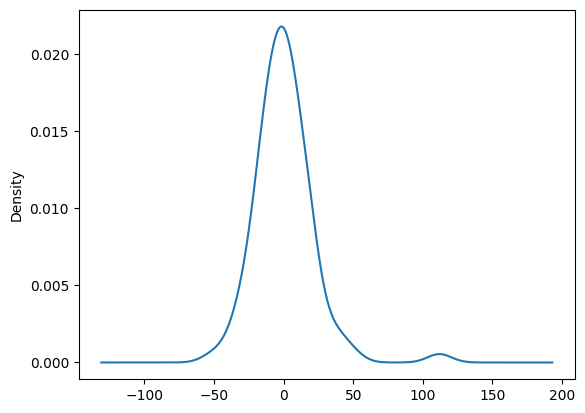

In [73]:
model_arima_fit.resid.plot(kind='kde')

In [74]:
test_data['Predicted_Arima'] = pred

/var/folders/lh/rhcpvjfx523gn0mxwb8kj1s80000gn/T/ipykernel_4640/6199056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Arima'] = pred


<Axes: xlabel='Month'>

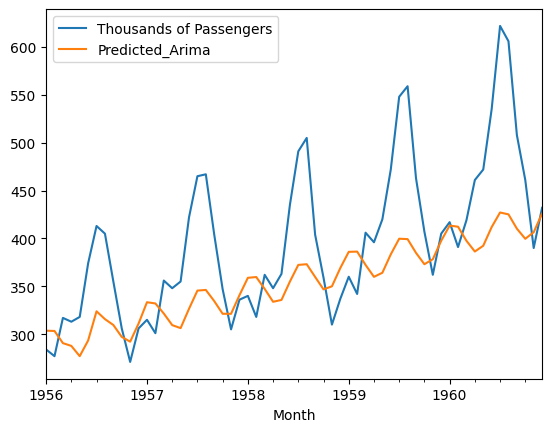

In [75]:
test_data[['Thousands of Passengers','Predicted_Arima']].plot()

In [80]:
model_arima_12 = ARIMA(test_data['Thousands of Passengers'],order=(3,0,5))

/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [81]:
model_arima_12_fit = model_arima_12.fit()

/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
model_arima_12_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   60
Model:                      ARIMA(3, 0, 5)   Log Likelihood                -300.981
Date:                     Sun, 20 Oct 2024   AIC                            621.963
Time:                             19:06:30   BIC                            642.906
Sample:                         01-01-1956   HQIC                           630.155
                              - 12-01-1960                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        396.4147     55.403      7.155      0.000     287.826     505.003
ar.L1          0.1381      0.514      0.269      0.788      -0.869       1.145
ar.L2          0.4404      0.518      0.851      0.395      -0.574       1.455
ar.L3          0.3368      0.252      1.337      0.181      -0.157       0.831
ma.L1          1.2432      0.745      1.668      0.095      -0.217       2.704
ma.L2          0.5947      3.745      0.159      0.874      -6.746       7.936
ma.L3         -0.2506      1.792     -0.140      0.889      -3.763       3.262
ma.L4         -1.0738      3.014     -0.356      0.722      -6.982       4.834
ma.L5         -0.6147      1.876     -0.328      0.743      -4.291       3.062
sigma2      1170.7549   3655.101      0.320      0.749   -5993.111    8334.620
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.83   Prob(JB):                         0.32
Heteroskedasticity (H):               2.43   Skew:                             0.46
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = model_arima_fit.predict(start=pred_start_date,end=pred_end_date)

In [84]:
pred_arima_12 = model_arima_12_fit.predict(start=pred_start_date,end=pred_end_date)
residuals_arima_12 = test_data['Thousands of Passengers']-pred_arima_12

In [85]:
pred_arima_12

1956-01-01    396.414707
1956-02-01    303.476363
1956-03-01    302.903931
1956-04-01    350.519819
1956-05-01    324.420457
1956-06-01    332.244392
1956-07-01    385.598645
1956-08-01    433.216402
1956-09-01    378.918219
1956-10-01    318.367913
1956-11-01    310.603145
1956-12-01    292.908543
1957-01-01    337.238262
1957-02-01    318.536319
1957-03-01    324.467826
1957-04-01    365.890538
1957-05-01    352.517255
1957-06-01    369.855726
1957-07-01    414.717191
1957-08-01    489.916828
1957-09-01    434.050125
1957-10-01    335.530247
1957-11-01    342.810835
1957-12-01    327.311094
1958-01-01    362.284314
1958-02-01    324.917922
1958-03-01    349.516994
1958-04-01    369.004059
1958-05-01    348.381498
1958-06-01    382.083387
1958-07-01    440.750818
1958-08-01    515.096724
1958-09-01    462.689444
1958-10-01    322.865367
1958-11-01    364.794894
1958-12-01    319.918389
1959-01-01    385.289406
1959-02-01    326.512199
1959-03-01    388.856463
1959-04-01    412.462170


In [86]:
residuals_arima_12

Month
1956-01-01   -112.414707
1956-02-01    -26.476363
1956-03-01     14.096069
1956-04-01    -37.519819
1956-05-01     -6.420457
1956-06-01     41.755608
1956-07-01     27.401355
1956-08-01    -28.216402
1956-09-01    -23.918219
1956-10-01    -12.367913
1956-11-01    -39.603145
1956-12-01     13.091457
1957-01-01    -22.238262
1957-02-01    -17.536319
1957-03-01     31.532174
1957-04-01    -17.890538
1957-05-01      2.482745
1957-06-01     52.144274
1957-07-01     50.282809
1957-08-01    -22.916828
1957-09-01    -30.050125
1957-10-01     11.469753
1957-11-01    -37.810835
1957-12-01      8.688906
1958-01-01    -22.284314
1958-02-01     -6.917922
1958-03-01     12.483006
1958-04-01    -21.004059
1958-05-01     14.618502
1958-06-01     52.916613
1958-07-01     50.249182
1958-08-01    -10.096724
1958-09-01    -58.689444
1958-10-01     36.134633
1958-11-01    -54.794894
1958-12-01     17.081611
1959-01-01    -25.289406
1959-02-01     15.487801
1959-03-01     17.143537
1959-04-01    -16.4

<Axes: ylabel='Density'>

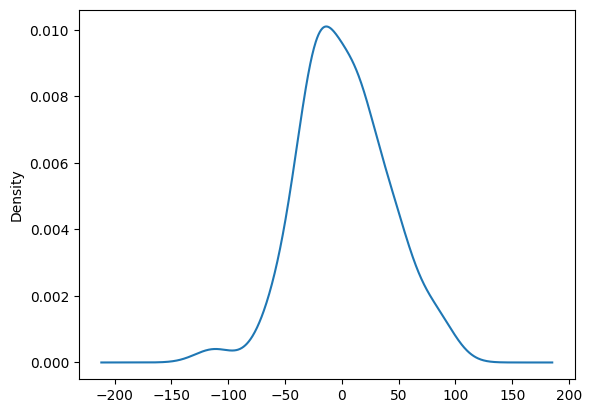

In [87]:
model_arima_12_fit.resid.plot(kind='kde')

In [88]:
test_data['Predicted_Arima_12'] = pred_arima_12

/var/folders/lh/rhcpvjfx523gn0mxwb8kj1s80000gn/T/ipykernel_4640/1424714888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Arima_12'] = pred_arima_12


<Axes: xlabel='Month'>

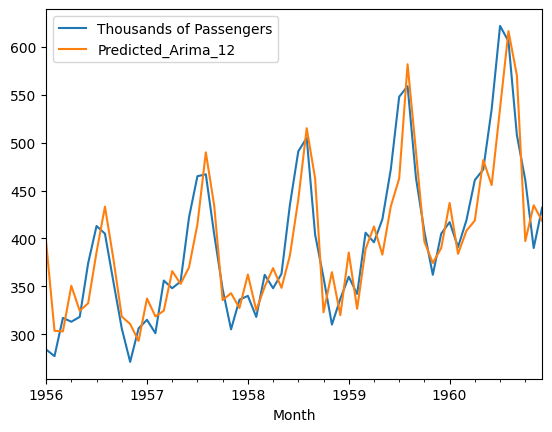

In [89]:
test_data[['Thousands of Passengers','Predicted_Arima_12']].plot()

## Now Let's check with SARIMAX

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [102]:
model_sarimax = SARIMAX(test_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))

/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sushantkotwal96/tensorflow_vs_code/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [103]:
model_sarimax_fit = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28358D+00    |proj g|=  3.53095D-02

At iterate    5    f=  3.27226D+00    |proj g|=  3.34105D-02

At iterate   10    f=  3.25896D+00    |proj g|=  5.38303D-02

At iterate   15    f=  3.25436D+00    |proj g|=  2.53292D-03


 This problem is unconstrained.



At iterate   20    f=  3.25418D+00    |proj g|=  2.14791D-03

At iterate   25    f=  3.25410D+00    |proj g|=  3.29213D-04

At iterate   30    f=  3.25408D+00    |proj g|=  1.69000D-03

At iterate   35    f=  3.25404D+00    |proj g|=  1.20535D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     43      1     0     0   2.120D-05   3.254D+00
  F =   3.2540448450251973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [104]:
model_sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   60
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -195.243
Date:                             Sun, 20 Oct 2024   AIC                            408.485
Time:                                     19:30:54   BIC                            425.326
Sample:                                 01-01-1956   HQIC                           414.850
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5380      1.552      0.347      0.729      -2.503       3.580
ar.L2          0.5232      0.613      0.853      0.394      -0.679       1.725
ar.L3         -0.1012      1.207     -0.084      0.933      -2.467       2.264
ma.L1          0.1381      1.501      0.092      0.927      -2.804       3.080
ma.L2         -0.1474      0.794     -0.186      0.853      -1.703       1.408
ma.L3          0.0464      0.319      0.145      0.884      -0.579       0.672
ma.L4         -0.3508      0.292     -1.200      0.230      -0.924       0.222
ma.L5          0.1969      0.606      0.325      0.745      -0.992       1.385
sigma2       186.6175     55.550      3.359      0.001      77.742     295.493
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.90   Prob(JB):                         0.62
Heteroskedasticity (H):               3.71   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
sarimax_12_pred = model_sarimax_fit.predict(start=pred_start_date,end=pred_end_date)
residuals_sarimax_12 = test_data['Thousands of Passengers']-sarimax_12_pred

In [106]:
sarimax_12_pred

1956-01-01      0.000000
1956-02-01      0.384820
1956-03-01      0.750631
1956-04-01      1.152176
1956-05-01      1.527345
1956-06-01      1.909676
1956-07-01      2.346954
1956-08-01      2.829434
1956-09-01      3.280752
1956-10-01      3.650147
1956-11-01      3.941381
1956-12-01      4.178452
1957-01-01    288.455941
1957-02-01    305.506741
1957-03-01    342.199599
1957-04-01    344.514082
1957-05-01    352.152352
1957-06-01    410.201593
1957-07-01    450.855439
1957-08-01    455.638763
1957-09-01    410.031084
1957-10-01    354.693842
1957-11-01    310.172310
1957-12-01    339.978284
1958-01-01    348.876463
1958-02-01    327.471213
1958-03-01    375.377420
1958-04-01    357.303311
1958-05-01    358.974585
1958-06-01    428.464786
1958-07-01    478.839618
1958-08-01    488.343618
1958-09-01    434.237953
1958-10-01    357.145257
1958-11-01    309.746298
1958-12-01    340.204122
1959-01-01    355.206461
1959-02-01    323.337384
1959-03-01    387.180610
1959-04-01    383.394060


In [107]:
residuals_sarimax_12

Month
1956-01-01    284.000000
1956-02-01    276.615180
1956-03-01    316.249369
1956-04-01    311.847824
1956-05-01    316.472655
1956-06-01    372.090324
1956-07-01    410.653046
1956-08-01    402.170566
1956-09-01    351.719248
1956-10-01    302.349853
1956-11-01    267.058619
1956-12-01    301.821548
1957-01-01     26.544059
1957-02-01     -4.506741
1957-03-01     13.800401
1957-04-01      3.485918
1957-05-01      2.847648
1957-06-01     11.798407
1957-07-01     14.144561
1957-08-01     11.361237
1957-09-01     -6.031084
1957-10-01     -7.693842
1957-11-01     -5.172310
1957-12-01     -3.978284
1958-01-01     -8.876463
1958-02-01     -9.471213
1958-03-01    -13.377420
1958-04-01     -9.303311
1958-05-01      4.025415
1958-06-01      6.535214
1958-07-01     12.160382
1958-08-01     16.656382
1958-09-01    -30.237953
1958-10-01      1.854743
1958-11-01      0.253702
1958-12-01     -3.204122
1959-01-01      4.793539
1959-02-01     18.662616
1959-03-01     18.819390
1959-04-01     12.6

<Axes: ylabel='Density'>

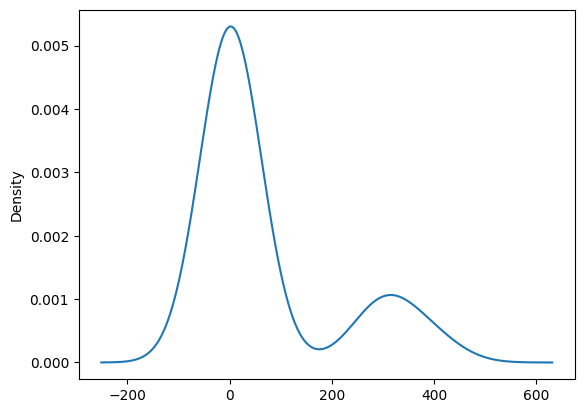

In [108]:
model_sarimax_fit.resid.plot(kind='kde')

In [109]:
test_data['Sarimax_Pred'] = sarimax_12_pred

/var/folders/lh/rhcpvjfx523gn0mxwb8kj1s80000gn/T/ipykernel_4640/4221293394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Sarimax_Pred'] = sarimax_12_pred


<Axes: xlabel='Month'>

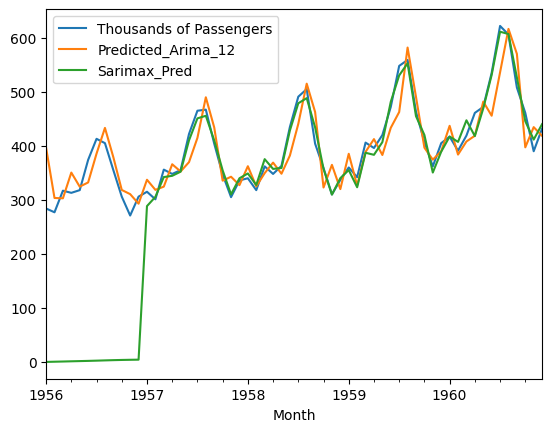

In [110]:
test_data[['Thousands of Passengers','Predicted_Arima_12','Sarimax_Pred']].plot()

## Since Data is Seasonal, it works better on SARIMAX than on ARIMA

In [114]:
!pip install pmdarima

     |████████████████████████████████| 630 kB 4.9 MB/s eta 0:00:01
You should consider upgrading via the '/Users/sushantkotwal96/tensorflow_vs_code/bin/python3 -m pip install --upgrade pip' command.


In [115]:
from pmdarima import auto_arima

In [118]:
auto_arima_model = auto_arima(train_data['Thousands of Passengers'],trace=True,seasonal=True,m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=542.053, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=597.376, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=536.684, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=560.740, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=696.878, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=540.380, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=538.290, Time=0.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=538.461, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=536.644, Time=0.12 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=538.298, Time=0.27 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=539.788, Time=0.63 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=589.655, Time=0.06 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=537.805, Time=0.11 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=538.008, Time=0.14 sec
 ARIMA(2,0,1)(0,1,1)[12] intercep